In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Загрузка и подготовка
df = pd.read_csv('smooth_sales_data_40_days.csv', parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)
df['revenue'] = df['quantity'] * df['price']
df['day_of_week'] = df['date'].dt.dayofweek
df['day_index'] = np.arange(len(df))  # Тренд
df['revenue_lag_1'] = df['revenue'].shift(1)
df['revenue_lag_2'] = df['revenue'].shift(2)
df['revenue_ma_3'] = df['revenue'].rolling(window=3).mean().shift(1)
df['revenue_ma_7'] = df['revenue'].rolling(window=7).mean().shift(1)

df_clean = df.dropna()

X = df_clean[['day_of_week', 'price', 'day_index', 'revenue_lag_1', 'revenue_lag_2', 'revenue_ma_3', 'revenue_ma_7']]
y = df_clean['revenue']

# Разделение с ограничением 30 дней (тренировочные и тестовые)
test_size = 7
total_size = len(X)

if total_size > 30:
    train_size = 30 - test_size
    X_train = X.iloc[-(30):-test_size]
    y_train = y.iloc[-(30):-test_size]
    print(f"Используются последние {len(X_train)} дней для обучения")
else:
    X_train = X.iloc[:-test_size]
    y_train = y.iloc[:-test_size]
    print(f"Используются все {len(X_train)} дней для обучения (меньше 30)")

X_test = X.iloc[-test_size:]
y_test = y.iloc[-test_size:]

# Подбор гиперпараметра alpha с TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {'ridge__alpha': [0.1, 1.0, 10.0, 100.0]}
model = make_pipeline(StandardScaler(), Ridge())

grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Предсказания
y_pred = best_model.predict(X_test)

# Метрики
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Лучший alpha: {grid_search.best_params_['ridge__alpha']}")
print(f"Средняя выручка: {y_test.mean():.2f}")
print(f"MAE (% от средней): {mae / y_test.mean():.2f}")
print(f"RMSE (% от средней): {rmse / y_test.mean():.2f}")

# Прогноз на 7 дней вперед (с новыми признаками)
last_row = df.iloc[-1].copy()
future_dates = pd.date_range(start=last_row['date'] + pd.Timedelta(days=1), periods=7, freq='D')

predictions = []
current_data = df.copy()

for i in range(7):
    next_date = current_data['date'].iloc[-1] + pd.Timedelta(days=1)
    day_index = current_data['day_index'].iloc[-1] + 1
    day_of_week = next_date.dayofweek
    price = current_data['price'].iloc[-1]
    revenue_lag_1 = current_data['revenue'].iloc[-1]
    revenue_lag_2 = current_data['revenue'].iloc[-2] if len(current_data) > 1 else revenue_lag_1
    revenue_ma_3 = current_data['revenue'].tail(3).mean()
    revenue_ma_7 = current_data['revenue'].tail(7).mean()

    new_row = {
        'date': next_date,
        'day_of_week': day_of_week,
        'price': price,
        'day_index': day_index,
        'revenue_lag_1': revenue_lag_1,
        'revenue_lag_2': revenue_lag_2,
        'revenue_ma_3': revenue_ma_3,
        'revenue_ma_7': revenue_ma_7
    }

    X_pred = pd.DataFrame([new_row])[['day_of_week', 'price', 'day_index', 'revenue_lag_1', 'revenue_lag_2', 'revenue_ma_3', 'revenue_ma_7']]
    pred = best_model.predict(X_pred)[0]
    pred = max(0, pred)

    new_row['revenue'] = pred
    current_data = pd.concat([current_data, pd.DataFrame([new_row])], ignore_index=True)
    predictions.append(pred)

forecast_df = pd.DataFrame({
    'date': future_dates,
    'predicted_revenue': predictions
})

print("\nПрогноз выручки (quantity * price) на следующие 7 дней:")
print(forecast_df)


Используются последние 23 дней для обучения
Лучший alpha: 1.0
Средняя выручка: 1429.37
MAE (% от средней): 0.05
RMSE (% от средней): 0.07

Прогноз выручки (quantity * price) на следующие 7 дней:
        date  predicted_revenue
0 2024-02-10        1337.982608
1 2024-02-11        1305.379716
2 2024-02-12        1502.226948
3 2024-02-13        1625.418260
4 2024-02-14        1633.057157
5 2024-02-15        1554.037046
6 2024-02-16        1465.551714


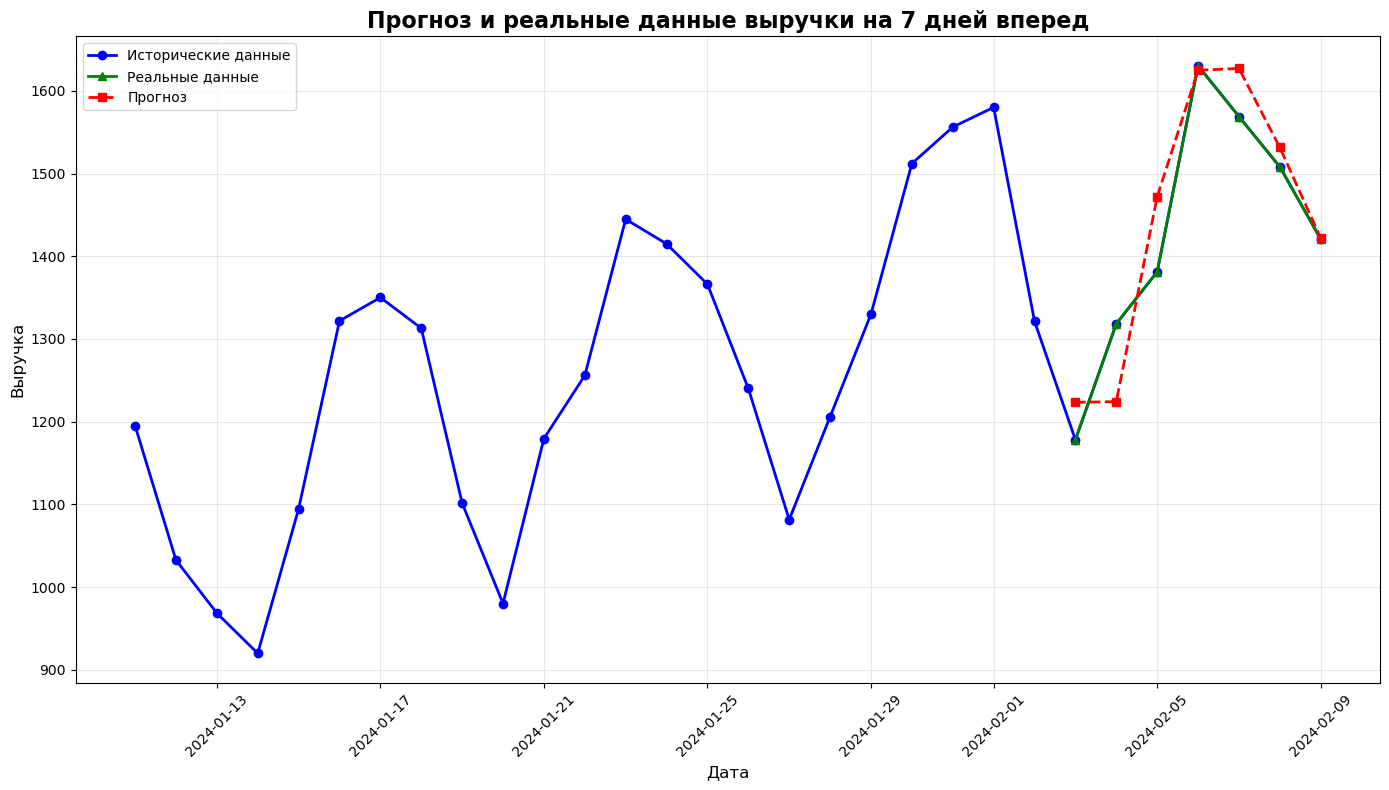


Сравнение прогноза и реальных данных за 7 дней:
      date  predicted_revenue  actual_revenue
2024-02-03        1223.360928        1177.994
2024-02-04        1224.161868        1318.350
2024-02-05        1471.885111        1381.104
2024-02-06        1624.857509        1630.352
2024-02-07        1627.046712        1568.880
2024-02-08        1531.514316        1508.029
2024-02-09        1421.788801        1420.848


In [2]:
import matplotlib.pyplot as plt
# Загрузка и подготовка
df = pd.read_csv('smooth_sales_data_40_days.csv', parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)
df['revenue'] = df['quantity'] * df['price']
df['day_of_week'] = df['date'].dt.dayofweek
df['revenue_lag_1'] = df['revenue'].shift(1)

df_clean = df.dropna()
# Выбираем реальные данные за последние 7 дней из исходного датафрейма
actual_future = df.sort_values('date').tail(7)

plt.figure(figsize=(14, 8))

# Исторические данные (последние 30 дней)
historical = df_clean.tail(30)
plt.plot(historical['date'], historical['revenue'], 
         label='Исторические данные', color='blue', linewidth=2, marker='o')

# Реальные данные за дни прогноза (последние 7 дней)
plt.plot(actual_future['date'], actual_future['revenue'], 
         label='Реальные данные', color='green', linewidth=2, marker='^')

# Прогноз
plt.plot(forecast_df['date'], forecast_df['predicted_revenue'], 
         label='Прогноз', color='red', linewidth=2, marker='s', linestyle='--')

plt.title('Прогноз и реальные данные выручки на 7 дней вперед', fontsize=16, fontweight='bold')
plt.ylabel('Выручка', fontsize=12)
plt.xlabel('Дата', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Вывод таблицы с прогнозом и реальными данными для сравнения
comparison_df = forecast_df.copy()
comparison_df['actual_revenue'] = actual_future.set_index('date').reindex(forecast_df['date'])['revenue'].values

print("\nСравнение прогноза и реальных данных за 7 дней:")
print(comparison_df.to_string(index=False))


In [65]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Генерация плавных данных на 40 дней
np.random.seed(42)  # Для воспроизводимости

start_date = datetime(2024, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(40)]

# Базовый тренд + сезонность + шум
base_trend = np.linspace(1000, 1500, 40)  # Плавный рост
weekly_seasonality = 200 * np.sin(2 * np.pi * np.arange(40) / 7)  # Недельная сезонность
noise = np.random.normal(0, 50, 40)  # Небольшой шум

# Общие продажи
total_sales = base_trend + weekly_seasonality + noise
total_sales = np.maximum(total_sales, 200)  # Минимум 200

# Генерация quantity и price с реалистичной корреляцией
# В обычные дни quantity выше, price ниже, в выходные - наоборот
quantities = []
prices = []

for i, date in enumerate(dates):
    day_of_week = date.weekday()
    
    if day_of_week >= 5:  # Выходные
        quantity = np.random.normal(8, 2)  # Меньше quantity
        price = np.random.normal(180, 20)  # Выше price
    else:  # Будни
        quantity = np.random.normal(15, 3)  # Больше quantity
        price = np.random.normal(120, 15)  # Ниже price
    
    # Корректируем чтобы total_sales ≈ quantity * price
    current_total = quantity * price
    target_total = total_sales[i]
    
    # Плавно корректируем price для соответствия total_sales
    adjustment = target_total / current_total
    price *= adjustment
    
    quantities.append(max(1, quantity))  # Минимум 1 штука
    prices.append(max(50, price))  # Минимум 50 рублей

# Создаем DataFrame
df = pd.DataFrame({
    'date': dates,
    'quantity': quantities,
    'price': prices,
    'total_sales': total_sales
})

# Пересчитываем total_sales на основе сгенерированных quantity и price
df['total_sales'] = df['quantity'] * df['price']

# Округляем значения
df['quantity'] = df['quantity'].round(1)
df['price'] = df['price'].round(2)
df['total_sales'] = df['total_sales'].round(2)

# Сохраняем в CSV
df.to_csv('smooth_sales_data_40_days.csv', index=False)

print("Сгенерировано 40 дней плавных данных:")
print(f"Период: {df['date'].min().strftime('%d.%m.%Y')} - {df['date'].max().strftime('%d.%m.%Y')}")
print(f"Общий объем продаж: {df['total_sales'].sum():,.2f} руб.")
print(f"Среднедневные продажи: {df['total_sales'].mean():,.2f} руб.")
print(f"Диапазон quantity: {df['quantity'].min():.1f} - {df['quantity'].max():.1f}")
print(f"Диапазон price: {df['price'].min():.2f} - {df['price'].max():.2f} руб.")
print("\nПервые 10 дней:")
print(df.head(10).to_string(index=False))

print(f"\nФайл сохранен как 'smooth_sales_data_40_days.csv'")

Сгенерировано 40 дней плавных данных:
Период: 01.01.2024 - 09.02.2024
Общий объем продаж: 49,914.11 руб.
Среднедневные продажи: 1,247.85 руб.
Диапазон quantity: 6.6 - 19.4
Диапазон price: 59.44 - 184.92 руб.

Первые 10 дней:
      date  quantity  price  total_sales
2024-01-01      17.2  59.53      1024.84
2024-01-02      14.7  79.32      1162.27
2024-01-03      10.6 118.61      1253.01
2024-01-04      13.6  88.22      1201.39
2024-01-05      16.0  59.44       952.80
2024-01-06       8.6  99.14       857.41
2024-01-07       6.6 150.39       999.52
2024-01-08      18.1  62.35      1128.12
2024-01-09      12.5  98.98      1235.46
2024-01-10      16.0  83.63      1337.50

Файл сохранен как 'smooth_sales_data_40_days.csv'
